# TSNE for vector representation techniques: Bow, Tf-idf, Avg word2vec and Tf-idf Word2vec

So we are plotting here the tsne for each and every vector representation technique for Amazon Fine Food review data set which conatins data of 364k reviews of different product

Importing all required packages 

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

C:\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#Saving Stopwords in our local hard disk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Connecting with database
conn=sqlite3.connect('database.sqlite')

#Selecting Score column in table to replace with positive and negative review
filtered_data=pd.read_sql_query('''SELECT * FROM Reviews WHERE Score !=3''',conn)

#Function for substituting rating<3 as 0 and rating > 3 as 1
def partition(x):
    if x<3:
        return 0
    return 1

#Taking score column data in different variable and substitue it with 1 and 0
actualScore=filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score']= positiveNegative

#Print of number of point of data we have and first 3 entries
print("Number of points present in our data:",filtered_data.shape)
filtered_data.head(3)


Number of points present in our data: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In our data there is so much of duplicates data so to remove such data we can use Pandas drop_duplicates.


In [4]:
#Sorting data in ascending order to ease deletion of duplicates
sortedData=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [5]:
final= sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

Above is the shape of our data shows that there are 364173 number of row/review and 10 dimension/column and also we have deleted all entries where userId, profilename,time and text are same by only keeping 1st data and deleting all other

In [6]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

It shows that still 69.25% of data remains after deleting duplicate data

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

Also it is criteria that helpfulness numerator should should not be greater than helpfulness denominator, so we are removing such data where this condition not satisfy.

In [17]:
print(final.shape)
final['Score'].value_counts()

(364171, 12)


positive    307061
negative     57110
Name: Score, dtype: int64

Above we can observe the final shape ie 364171 reviews and 10 columns and total number of positive review ie 307061 and negative review ie 57110

In [16]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In above snippet we are printing all html tags and removing it in below code snippet

In [10]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags by space
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters  and substitue it with space
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))#getting stem word for Tasty

{'down', "don't", 'myself', 'against', 'needn', "didn't", 'it', 'no', "shan't", 'into', 'did', 'their', 'haven', 'you', 'will', 'once', 'was', 'don', 'only', 'each', 'weren', 'yourselves', 'whom', 'off', 'we', 'itself', 'him', 'have', 'up', 'm', 'your', "you'll", 'at', 'by', 'should', 'ma', 'during', 'doesn', 'but', 'most', 'himself', 'other', 'y', "that'll", "you've", 'didn', 'some', 'through', 'am', 'not', 'very', 'own', 'shouldn', 'her', 'because', 'both', 'why', 'on', 'won', 'd', 'ourselves', 'what', 'these', 'from', 'an', 'which', "won't", 'his', 'our', "needn't", 'who', 'that', "mightn't", 'in', 'them', 'nor', 'if', 'she', 'before', 'over', 'aren', "doesn't", 'same', 'above', 'o', 'wouldn', 'been', 'mightn', 'for', 'so', 'theirs', 's', 'he', 'themselves', 're', 'is', "isn't", 'further', 'are', 'while', 'be', 'yours', "wasn't", 'this', "couldn't", 'below', 'me', "hasn't", 'they', 'after', 'were', 'more', 'i', 'than', 'has', 'having', 'a', "haven't", "hadn't", 'and', 'as', "mustn't

In [11]:
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():#splitting the word
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [12]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# Bow: Bag of words

In [13]:
#Converting review into Bag of Words
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 71624)
the number of unique words  71624


In [14]:
#Picking only 2k data as it is throwing memory error
Bow_Final_500=final_counts[:2000,:].toarray()

#Similarly picking 2k points from score cloumn
Bow_Score_500=final["Score"][:2000]
#Bow_Score_500= Bow_Score_500.replace({1:'Positive',0:'Negative'})

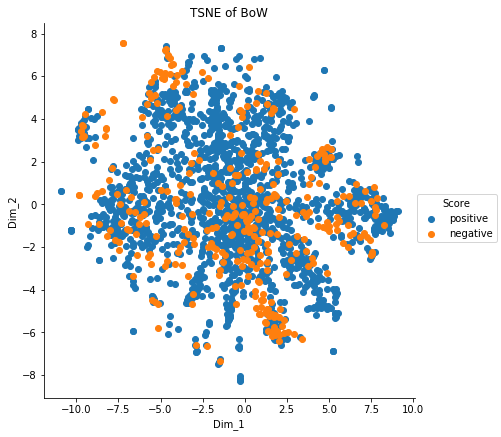

In [45]:
#plotting tsne for BoW
from sklearn.manifold import TSNE
model=TSNE(n_components=2, random_state=0,perplexity=100,n_iter=5000)
tsne_data = model.fit_transform(Bow_Final_500)
tsne_data = np.vstack((tsne_data.T,Bow_Score_500)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE of BoW")
plt.show()


In above TSNE we observe that the the blue points are positive review and orange review are negative points but we cannot simply distinguish by any plane between positive review and neagtive review

# Tf-idf 

In [20]:
#Taking sample of 1000 from each postive and negative reviews and concatenate it
positive_1000=final[final['Score']=='positive'].sample(n=1000)
negative_1000=final[final['Score']=='negative'].sample(n=1000)
final_2000=pd.concat([positive_1000,negative_1000])

Due to machine configuration I took only 2k points 1k from positive and 1k from neagtive and conactenate it with each other and then represent it in vector form as below

In [46]:
#Tf_idf of concatenated 2000 points
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_2000['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 63245)
the number of unique words including both unigrams and bigrams  63245


Above we can observe that there are only 2000 review and 63245 number of rows because of unigrams and bigrams

In [24]:
#picking 2k points from 2k concatenated points
Tf_idf_Final=final_tf_idf[:2000,:].toarray()

Picking 2000 points as final text from final_2000

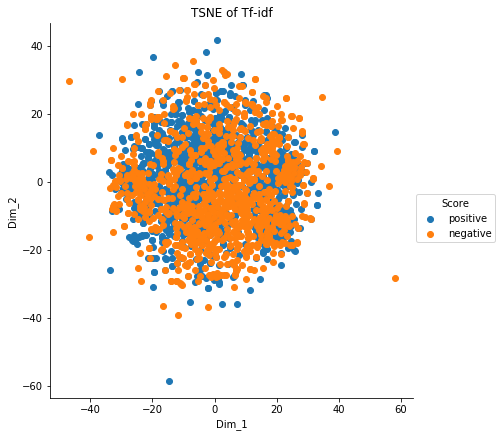

In [47]:
#Plottinf Tsne of Tf_idf
from sklearn.manifold import TSNE

model=TSNE(n_components=2, random_state=0,perplexity=100,n_iter=15000)
tsne_data = model.fit_transform(Tf_idf_Final)
tsne_data = np.vstack((tsne_data.T,final_2000['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE of Tf-idf")
plt.show()

Here also we can observe that we cannot distinguish between positve and negative review on TSNE of Tf-idf

In [26]:
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Above we are using word 2 vector model for our training purpose

# Avg Word2vec

In [35]:
i=0
list_of_sent=[]
for sent in final_2000['CleanedText'].values:
    list_of_sent.append(sent.split())

In above snippet I am only taking 2k points 

Sending list of list to model and setting minimum count of 5 occurence and setting dimension of 50 and making work all 4 cores

In [44]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

Getting all my vocablury in w2v_words

In [37]:
w2v_words = list(w2v_model.wv.vocab)


In [38]:
#Avg-Word2vec
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 957.72it/s]


2000
50


Above we are storing all review in list for Avg Word2vec

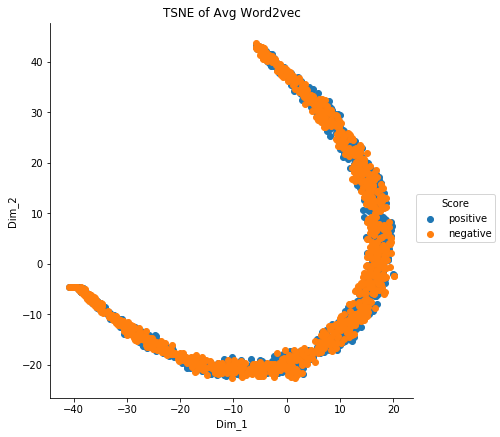

In [48]:
#plotting tsne for Avg word2vec
model=TSNE(n_components=2, random_state=0,perplexity=100,n_iter=15000)
tsne_data=model.fit_transform(sent_vectors)
tsne_data=np.vstack((tsne_data.T,final_2000["Score"])).T

tsne_df=pd.DataFrame(data=tsne_data,columns=("Dim_1","Dim_2","Score"))
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE of Avg Word2vec")
plt.show()

Here is also same result we canot able to distingush between postive review and negative review

# Tf-idf weighted word2vec

In [41]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_2000['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [42]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]            
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 677.01it/s]


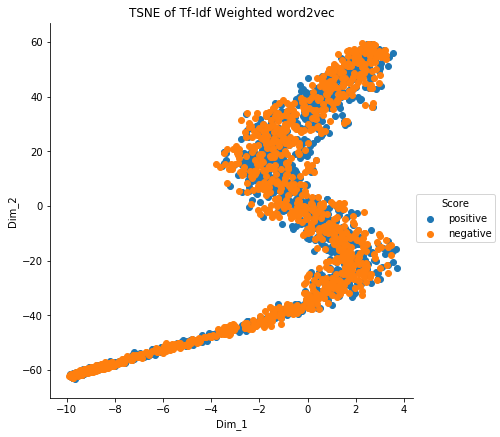

In [49]:
#plotting tsne of Tf-idf word2vec
model=TSNE(n_components=2, random_state=0,perplexity=100,n_iter=15000)
tsne_data=model.fit_transform(tfidf_sent_vectors)
tsne_data=np.vstack((tsne_data.T,final_2000["Score"])).T

tsne_df=pd.DataFrame(data=tsne_data,columns=("Dim_1","Dim_2","Score"))
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE of Tf-Idf Weighted word2vec")
plt.show()

As we can observe in TSNE of weighted tf-idf also we cannot easily distinguish between the postive and neagtive review


# Conclusion:

Sucessfully plotted TSNE for different vector representation technique but it has been observed that none of the vector representation give distinguishable visulization of postive and neagtive reviews